# Домашнее задание 4. Поиск аномалий
**Дедлайн 23:59 07.12.2018**



# Задача
[Данные](http://odds.cs.stonybrook.edu/seismic-dataset/) представляют собой показания о сейсмических активностях вулканов. Задача имеет очень важное практическое значение. Ещё недавно эта задача требовала большой квалификации экспертов и была очень сложной. Однако сейчас, в эпоху машинного обучения, за вас учится компьютер. Однако вот незадача: за всю историю геонаблюдений наблюдалось всего несколько (170) землятрясений, в то время как нормальных геосостояний окрестностей наблюдалось очень много (~2500). Перед Вами стоит задача наиболее эффективного поиска аномалий

# Условие
В рамках данной задачи Вам предлагается попробовать следующее:
1. Предложите метрику качества Вашей модели. Можно ли здесь использовать accuracy? Объясните свой выбор.
2. Проверьте гипотезу компактности на этих данных. Какие методы машинного обучения тут могут хорошо работать?
3. Обучите на данных любой классификатор. Хорошо ли он работает? Почему его качество может быть плохим в этой задаче?
4. Обучите методы поиска аномалий из [занятия 6](../Seminars/Lesson_6.ipynb). Добейтесь наилучшего качества. Лучше ли оно, чем supervised-learning? Почему?
5. Визуализируйте полученные наилучшей моделью предсказания. Хороша ли итоговая модель на этих данных?

# Примечание
1. Более подробное описание данных можно найти [тут](https://archive.ics.uci.edu/ml/datasets/seismic-bumps#)
2. Если эти данные Вам не нравятся - можете взять любые другие данные с аномалиями (кроме тироида) [отсюда](http://odds.cs.stonybrook.edu)

# Ссылки
https://dyakonov.org/2017/04/19/поиск-аномалий-anomaly-detection/

# Решение

## 0. Загрузка и предобработка данных

In [65]:
from scipy.io import arff
data, meta = arff.loadarff('./data/seismic-bumps.arff')

In [66]:
data

array([(b'a', b'a', b'N', 15180.,  48., -72., -72., b'a', 0., 0., 0., 0., 0., 0., 0., 0.,    0.,    0., b'0'),
       (b'a', b'a', b'N', 14720.,  33., -70., -79., b'a', 1., 0., 1., 0., 0., 0., 0., 0., 2000., 2000., b'0'),
       (b'a', b'a', b'N',  8050.,  30., -81., -78., b'a', 0., 0., 0., 0., 0., 0., 0., 0.,    0.,    0., b'0'),
       ...,
       (b'b', b'a', b'W', 26960., 540., 101., 112., b'a', 0., 0., 0., 0., 0., 0., 0., 0.,    0.,    0., b'0'),
       (b'a', b'a', b'W', 16130., 322.,   2.,   2., b'a', 0., 0., 0., 0., 0., 0., 0., 0.,    0.,    0., b'0'),
       (b'a', b'a', b'W', 12750., 235., -10., -10., b'a', 0., 0., 0., 0., 0., 0., 0., 0.,    0.,    0., b'0')],
      dtype=[('seismic', 'S1'), ('seismoacoustic', 'S1'), ('shift', 'S1'), ('genergy', '<f8'), ('gpuls', '<f8'), ('gdenergy', '<f8'), ('gdpuls', '<f8'), ('ghazard', 'S1'), ('nbumps', '<f8'), ('nbumps2', '<f8'), ('nbumps3', '<f8'), ('nbumps4', '<f8'), ('nbumps5', '<f8'), ('nbumps6', '<f8'), ('nbumps7', '<f8'), ('nbumps89

In [11]:
meta

Dataset: seismic-bumps
	seismic's type is nominal, range is ('a', 'b', 'c', 'd')
	seismoacoustic's type is nominal, range is ('a', 'b', 'c', 'd')
	shift's type is nominal, range is ('W', 'N')
	genergy's type is numeric
	gpuls's type is numeric
	gdenergy's type is numeric
	gdpuls's type is numeric
	ghazard's type is nominal, range is ('a', 'b', 'c', 'd')
	nbumps's type is numeric
	nbumps2's type is numeric
	nbumps3's type is numeric
	nbumps4's type is numeric
	nbumps5's type is numeric
	nbumps6's type is numeric
	nbumps7's type is numeric
	nbumps89's type is numeric
	energy's type is numeric
	maxenergy's type is numeric
	class's type is nominal, range is ('1', '0')

In [67]:
import pandas as pd
df = pd.DataFrame(data, columns=data.dtype.fields.keys())
df.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,b'a',b'a',b'N',15180.0,48.0,-72.0,-72.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
1,b'a',b'a',b'N',14720.0,33.0,-70.0,-79.0,b'a',1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0,b'0'
2,b'a',b'a',b'N',8050.0,30.0,-81.0,-78.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
3,b'a',b'a',b'N',28820.0,171.0,-23.0,40.0,b'a',1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0,b'0'
4,b'a',b'a',b'N',12640.0,57.0,-63.0,-52.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'


Данные сырые и явно требуют предобработки

In [68]:
df['class'] = df['class'].astype(int) # приведём целевую переменную к числовым значениям (1 - аномалия)

Руководствуясь метаинформацией о признаках (переменная meta выше) и таблицей выше, определите и преобразуйте категориальные признаки

In [25]:
df['seismic'].unique().dtype

dtype('O')

In [29]:
df['gpuls'].unique().dtype

dtype('float64')

In [69]:
categorical_features = [column for column in df.columns if df[column].unique().dtype == 'O']

In [70]:
categorical_features

['seismic', 'seismoacoustic', 'shift', 'ghazard']

In [71]:
# Проверяю, что именно LabelEncoder нужен
for c in df[categorical_features]:
    print(df[c].unique())

[b'a' b'b']
[b'a' b'b' b'c']
[b'N' b'W']
[b'a' b'b' b'c']


In [72]:
# Разброс значений небольшой, поэтому, полагаю, можно оставить ЛЭ.

In [73]:
from sklearn.preprocessing import LabelEncoder

transformers = {}
for feature_name in categorical_features:
    transformers[feature_name] = LabelEncoder()
    df[feature_name] = transformers[feature_name].fit_transform(df[feature_name])

df_oh = pd.get_dummies(df, columns=categorical_features, drop_first=True)

In [74]:
df_oh.head()

,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,...,nbumps89,energy,maxenergy,class,seismic_1,seismoacoustic_1,seismoacoustic_2,shift_1,ghazard_1,ghazard_2
0,15180.0,48.0,-72.0,-72.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,14720.0,33.0,-70.0,-79.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,2000.0,2000.0,0,0,0,0,0,0,0
2,8050.0,30.0,-81.0,-78.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,28820.0,171.0,-23.0,40.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,3000.0,3000.0,0,0,0,0,0,0,0
4,12640.0,57.0,-63.0,-52.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [75]:
# X, y = df.drop('class', 1), df['class']
X, y = df_oh.drop('class', 1), df_oh['class']

## 1.* Модельки

In [76]:
from sklearn.ensemble import IsolationForest
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
model = IsolationForest(contamination=y_train.mean())
model.fit(X_train)
preds = model.predict(X_test)
y_test[preds == 1].mean(), y_test[preds == -1].mean()

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0.08247422680412371, 0.0625)

In [77]:
from sklearn.neighbors import LocalOutlierFactor
model = LocalOutlierFactor(n_neighbors=100)
preds = model.fit_predict(X_test)
y_test[preds == 1].mean(), y_test[preds == -1].mean()

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0.06881720430107527, 0.19230769230769232)

In [78]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
y_test[preds == 0].mean(), y_test[preds == 1].mean()

(0.0784313725490196, 0.2857142857142857)

# Предложите метрику качества Вашей модели. Можно ли здесь использовать accuracy? Объясните свой выбор.

Наша задача – определить факт землятресения. Хотя задача и называется поиском аномалии, но все-равно для меня это задача бинарной классификации. Соответсвенно сюда пойдут: 
1) accuracy is the proportion of true results (both true positives and true negatives) among the total number of cases examined.
(TP+TN)/(TP+TN+FP+FN)

2) precision is defined as the number of true positives over the number of true positives plus the number of false positives.
TP/TP+FP
Ошибка первого рода

3) recall is defined as the number of true positives over the number of true positives plus the number of false negatives.
TP/TP+FN
Ошибка второго рода

Нам важно учитывать аккуратность модели, но и отлавливать как мы ошибаемся во время положительных позитивов.

# Проверьте гипотезу компактности на этих данных. Какие методы машинного обучения тут могут хорошо работать?

In [116]:
X.shape, y.shape

((2584, 20), (2584,))

In [117]:
from sklearn.manifold import TSNE
X_emb = TSNE(n_components=2).fit_transform(X)

In [118]:
X_emb.shape

(2584, 2)

In [126]:
y.shape

(2584,)

In [119]:
type(X_emb)

numpy.ndarray

In [120]:
type(y.values)

numpy.ndarray

In [121]:
y_with_col = pd.DataFrame(y)

In [122]:
y.shape, y_with_col.shape

((2584,), (2584, 1))

In [132]:
yy = y_with_col.values

In [124]:
X_emb.shape, yy.shape

((2584, 2), (2584, 1))

In [134]:
X_emb.shape, yy.shape, y_with_col.shape

((2584, 2), (2584, 1), (2584, 1))

In [133]:
type(X_emb), type(yy), type(y_with_col)

(numpy.ndarray, numpy.ndarray, pandas.core.frame.DataFrame)

In [137]:
np.unique(yy)

array([0, 1])

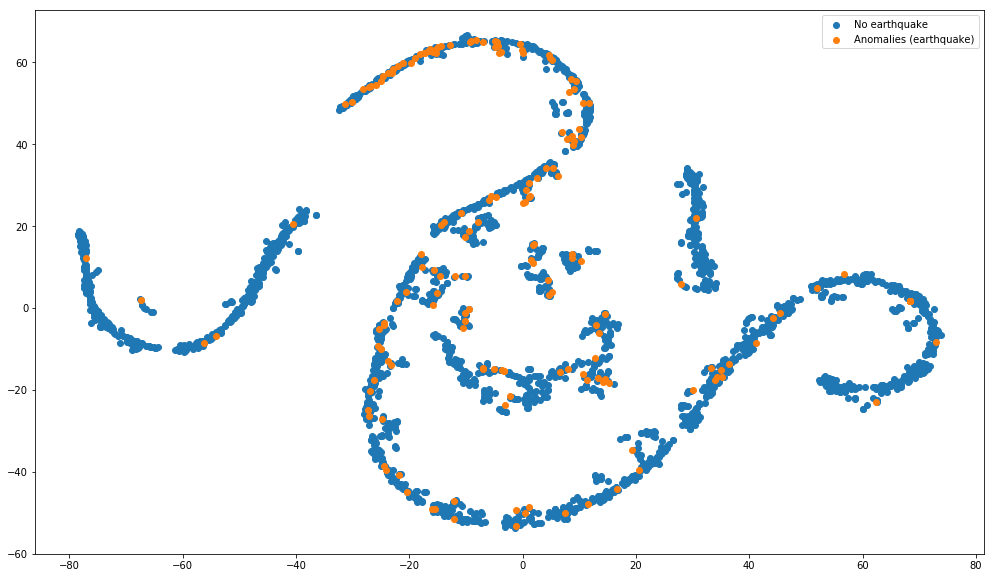

In [140]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.figure(figsize=(17,10))
normals_idx = np.argwhere(yy == 0).squeeze() 
anomalies_idx = np.argwhere(yy == 1).squeeze() 
plt.scatter(X_emb[normals_idx, 0], X_emb[normals_idx, 1], label='No earthquake')
plt.scatter(X_emb[anomalies_idx, 0], X_emb[anomalies_idx, 1], label='Anomalies (earthquake)')
plt.legend()

# Обучите на данных любой классификатор. Хорошо ли он работает? Почему его качество может быть плохим в этой задаче?

Выбросов и отдельностоящих выраженных кластеров нет.

In [142]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score

clf = LocalOutlierFactor(n_neighbors=12)
y_pred = clf.fit_predict(X_test) # возвращает предсказания {-1, 1}. -1 - аномалия
y_pred = (1 - y_pred) / 2 # нормируем так, чтобы -1 перешла в 1, а +1 перешла в 0

accuracy_score(y_pred, y_test)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


0.8259187620889749

In [162]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

clf = Pipeline([('scaler', StandardScaler()), ('estimator', OneClassSVM(degree=1, ))])
clf.fit(X_train.values[np.argwhere(y_train == 0)[:, 0]])
y_pred = clf.predict(X_test)
y_pred = (1 - y_pred) / 2

accuracy_score(y_pred, y_test)

0.4874274661508704

Качетво запредельно низкой, так как нет отдельностоящих кластеров, которые можно было бы разделить разделяющей поверхностью.

# Обучите методы поиска аномалий из занятия 6. Добейтесь наилучшего качества. Лучше ли оно, чем supervised-learning? Почему?

In [164]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train.values[np.argwhere(y_train == 0)[:,0]]) # обучим scaler только на хороших данных
X_transform = scaler.transform(X_test) # наши Z-value (это преобразование можно использовать для нормировки данных)

In [165]:
X_transform.shape

(517, 20)

In [166]:
preds = (X_transform < -3).astype(np.uint8).sum(axis=1) + (X_transform > 3).astype(np.uint8).sum(axis=1) # массив булевых значений. True - если выброс, False
y_test[preds > 0].mean(), y_test.mean()

(0.11290322580645161, 0.08123791102514506)

In [167]:
y_test[preds > 1].sum() * 100. / y_test.sum()

9.523809523809524

In [168]:
y_test[preds > 1].mean()

0.08

In [194]:
y_pred = (preds > 3).astype(np.uint8)

from sklearn.metrics import accuracy_score
accuracy_score(y_pred, y_test)

0.9013539651837524

Ответ: Работает лучше со значенями pred больше 3 
Почему? Extreme value theory or extreme value analysis (EVA) is a branch of statistics dealing with the extreme deviations from the median of probability distributions. It seeks to assess, from a given ordered sample of a given random variable, the probability of events that are more extreme than any previously observed.

Короче говоря, если обучится только об случаи, где не было землятрясений, то наложив все данные можно найти случаи, где присутсвует девиация распределений. Я так для себя понял.

# Визуализируйте полученные наилучшей моделью предсказания. Хороша ли итоговая модель на этих данных?

In [188]:
from sklearn.cross_validation import train_test_split
X_emb_train, X_emb_test, X_train, X_test, y_train, y_test = train_test_split(X_emb, X, y, train_size=0.8)

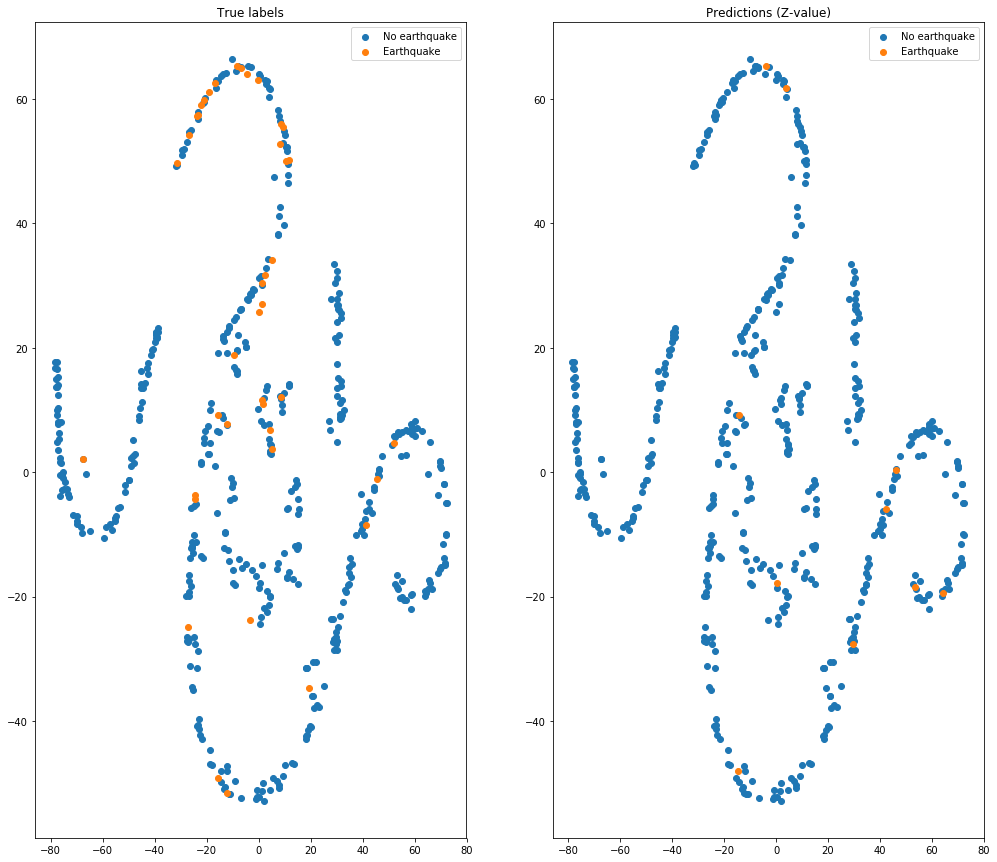

In [195]:
plt.figure(figsize=(17, 15))

plt.subplot(121)
plt.title('True labels')
normals_idx = np.argwhere(y_test.values == 0).squeeze() # No earthquake
anomalies_idx = np.argwhere(y_test.values == 1).squeeze() # Earthquake
plt.scatter(X_emb_test[normals_idx, 0], X_emb_test[normals_idx, 1], label='No earthquake')
plt.scatter(X_emb_test[anomalies_idx, 0], X_emb_test[anomalies_idx, 1], label='Earthquake')
plt.legend()

plt.subplot(122)
plt.title('Predictions (Z-value)')
normals_idx = np.argwhere(y_pred == 0).squeeze() # No earthquake
anomalies_idx = np.argwhere(y_pred == 1).squeeze() # Earthquake
plt.scatter(X_emb_test[normals_idx, 0], X_emb_test[normals_idx, 1], label='No earthquake')
plt.scatter(X_emb_test[anomalies_idx, 0], X_emb_test[anomalies_idx, 1], label='Earthquake')
plt.legend()